# Momentum Factor Validation

This notebook validates the momentum factor by splitting assets into 5 buckets (quintiles) based on their 12-day rolling returns (lagged by 1 day). 
We also apply a BTC 90-day return filter.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Import helper classes from local framework
from binance_data_loader import BinanceDataLoader
from backtest_framework import compute_sharpe, compute_sortino_ratio, compute_calmar_ratio

%matplotlib inline

## Load Data
We load daily Binance data using the `BinanceDataLoader`.

In [14]:
# Configure loader for daily data
data_loader = BinanceDataLoader(
    data_directory="/Users/chinjieheng/Documents/data/binance_dailydata",
    timeframe="1d",
    funding_rate_directory="/Users/chinjieheng/Documents/data/binance_fundingrate_data",
    min_records=31, # Higher to ensure BTC 90d + momentum 12d
    min_volume=1e5,
    start_date="2022-01-01", # Start earlier for validation
    end_date=None,
)

price = data_loader.get_price_matrix()
print(f"Price shape: {price.shape}")

# Extract volume data via the loader's universe dictionary
# Align volume with price index
volume_data = {t: data_loader._crypto_universe[t]['data']['volume'].reindex(price.index) for t in data_loader.get_universe()}
volume_df = pd.DataFrame(volume_data, index=price.index)
print(f"Volume shape: {volume_df.shape}")

# BTC Filter (90d return)
if 'BTCUSDT' in price.columns:
    btc_90d_ret = price['BTCUSDT'].pct_change(90)
else:
    print("BTCUSDT not found! BTC filter will not be applied.")
    btc_90d_ret = pd.Series(1.0, index=price.index)


Loading Binance data from /Users/chinjieheng/Documents/data/binance_dailydata (timeframe=1d)...
Found 611 USDT trading pairs
Using a 30-bar rolling window for 30d volume checks
✓ BTCUSDT loaded successfully with 1475 records, avg volume: 14,703,330,304
Loaded 600 cryptocurrencies
Filtered 8 cryptocurrencies (insufficient data/volume)
Precomputing returns matrix (FAST numpy version)...
Building returns matrix (Memory Optimized)...
Matrix shape: (1475, 600)
Precomputed returns matrix shape: (1475, 600)
Date range: 2022-01-01 00:00:00 to 2026-01-14 00:00:00
Loading funding rate data from /Users/chinjieheng/Documents/data/binance_fundingrate_data...
Found 613 funding rate files
Loaded funding rates for 600 symbols
Price shape: (1475, 600)
Volume shape: (1475, 600)


## Compute Momentum Factor
Momentum is defined as the 12-bar simple return, lagged by 1 bar to avoid lookahead/short-term reversal effects (as per user instruction).

In [15]:
# Volume filter parameter: only trade top x% of assets by volume
# Defaulting to top 20%
volume_top_pct = 0.2 

# Momentum: pct_change(12) lagged by 1 day
momentum_factor = price.pct_change(12).shift(1)

# Rolling Volatility (20-day) for inverse vol weighting
# We also lag it by 1 day to ensure weights are known before the return realization
rolling_vol = price.pct_change().rolling(20).std().shift(1)

# Rolling Volume (20-day average) for universe filtering
# Lagged by 1 day to avoid lookahead
rolling_volume = volume_df.rolling(20).mean().shift(1)

# Forward returns for backtesting (return from today's close to tomorrow's close)
fwd_returns = price.pct_change().shift(-1)


/var/folders/4j/50_b76mn3qj360c47nzkyxdc0000gn/T/ipykernel_83816/592208143.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  momentum_factor = price.pct_change(12).shift(1)
/var/folders/4j/50_b76mn3qj360c47nzkyxdc0000gn/T/ipykernel_83816/592208143.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rolling_vol = price.pct_change().rolling(20).std().shift(1)
/var/folders/4j/50_b76mn3qj360c47nzkyxdc0000gn/T/ipykernel_83816/592208143.py:17: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-lead

## Quantile Analysis
Every day, we rank coins into 5 buckets. We also exclude coins if the BTC 90d return is negative.

In [16]:
n_segments = 10 
bucket_returns = {}

# Inverse volatility calculation (1/vol)
inv_vol = 1.0 / rolling_vol.replace(0, np.nan)

# Volume Ranking: top x% daily
# We rank row-wise (axis=1) and select the top percentile
volume_ranks = rolling_volume.rank(axis=1, pct=True)
volume_mask = volume_ranks > (1.0 - volume_top_pct)

for bucket in range(n_segments):
    # Determine ranks each day ONLY for assets that pass the volume filter
    # We apply the filter BEFORE spliting into deciles to ensure deciles are
    # representative of the tradeable universe.
    
    # 1. Mask momentum values for assets NOT in the top volume universe
    filtered_momentum = momentum_factor.where(volume_mask, np.nan)
    
    # 2. Rank within this filtered universe
    ranks = filtered_momentum.rank(axis=1, pct=True)
    
    # Define bucket mask
    lower = bucket / n_segments
    upper = (bucket + 1) / n_segments
    
    # Selection mask: assets in this decile
    selection_mask = (ranks >= lower) & (ranks < upper)
    
    # BTC filter mask: do not trade if BTC 90d return < 0
    btc_mask = (btc_90d_ret >= 0).values.reshape(-1, 1) # Reshape for broadcasting
    
    # Combined filter: Selection AND BTC condition AND valid Inverse Vol
    active_mask = selection_mask & (btc_mask) & inv_vol.notna()
    
    # Apply weights: Inverse Volatility within the selected bucket
    weights = inv_vol.where(active_mask, 0.0)
    
    # Normalize weights row-wise
    row_sums = weights.sum(axis=1)
    norm_weights = weights.div(row_sums.replace(0, np.nan), axis=0).fillna(0)
    
    # Calculate weighted return for this bucket
    bucket_ret = (norm_weights * fwd_returns).sum(axis=1).fillna(0)
    
    bucket_returns[f'Decile_{bucket+1}'] = bucket_ret

df_returns = pd.DataFrame(bucket_returns)

# Shift index by 1 day to represent the date the return was realized
df_returns.index = df_returns.index + pd.Timedelta(days=1)


## Results Visualization

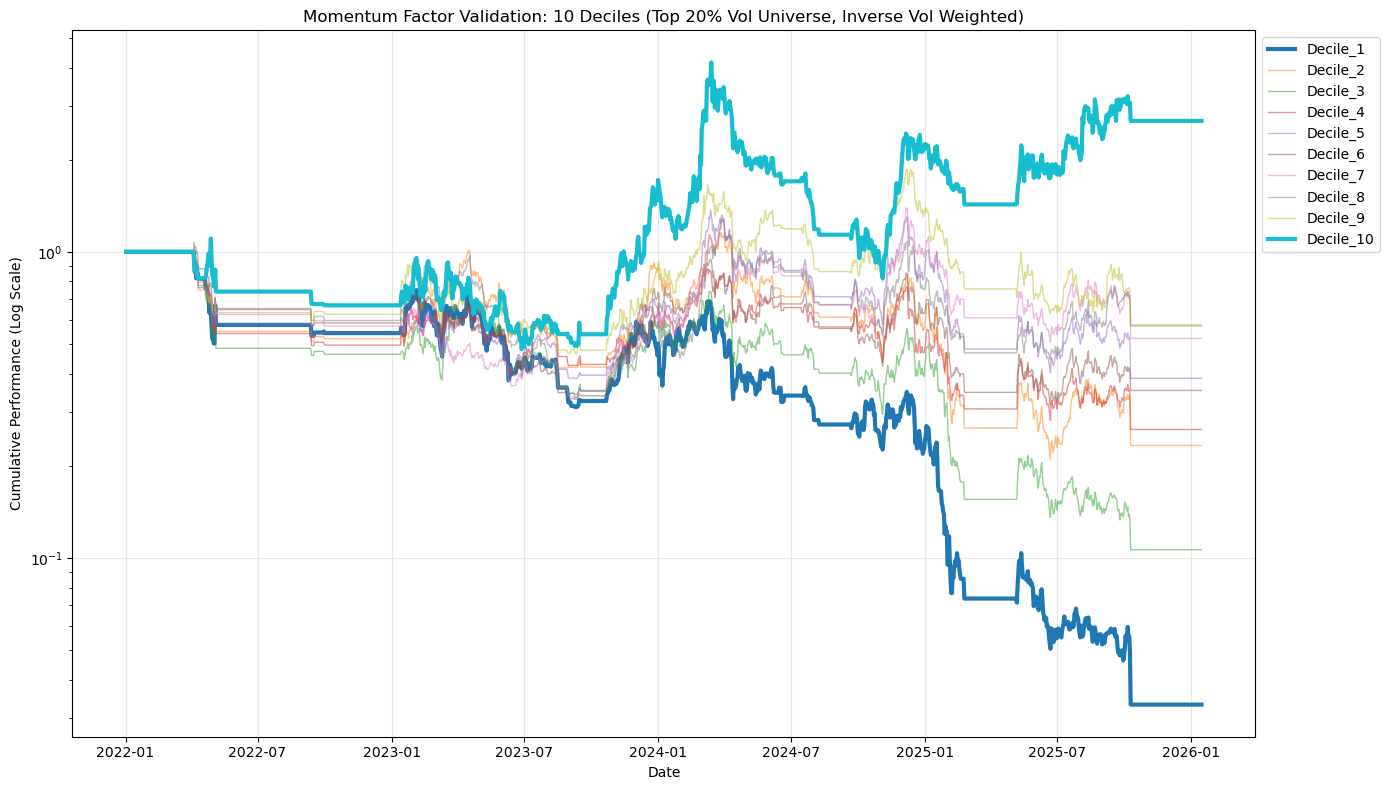

,Sharpe,Sortino,Total Return,Max Drawdown
Segment,,,,
Decile_1,-0.695141,-0.735369,-0.966811,-0.966811
Decile_2,-0.195011,-0.202148,-0.766939,-0.817932
Decile_3,-0.587388,-0.624496,-0.893629,-0.893629
Decile_4,-0.242652,-0.251243,-0.737057,-0.737057
Decile_5,-0.102495,-0.107519,-0.613670,-0.717339
Decile_6,-0.182660,-0.188269,-0.647417,-0.706152
Decile_7,0.005016,0.005418,-0.478495,-0.665609
Decile_8,0.068273,0.073399,-0.423769,-0.665797
Decile_9,0.104651,0.117572,-0.428569,-0.692877


In [17]:
# Plot cumulative returns
cumulative_returns = (1 + df_returns).cumprod()

plt.figure(figsize=(14, 8))
# Highlight Bottom Decile (D1) and Top Decile (D10)
for col in cumulative_returns.columns:
    linewidth = 3 if col in ['Decile_1', 'Decile_10'] else 1
    alpha = 1.0 if col in ['Decile_1', 'Decile_10'] else 0.5
    plt.plot(cumulative_returns[col], label=col, linewidth=linewidth, alpha=alpha)

plt.title(f'Momentum Factor Validation: 10 Deciles (Top {volume_top_pct*100:.0f}% Vol Universe, Inverse Vol Weighted)')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance (Log Scale)')
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compute Stats
stats = []
for col in df_returns.columns:
    rets = df_returns[col]
    stats.append({
        'Segment': col,
        'Sharpe': compute_sharpe(rets, periods_per_year=365),
        'Sortino': compute_sortino_ratio(rets, periods_per_year=365),
        'Total Return': (1 + rets).prod() - 1,
        'Max Drawdown': (cumulative_returns[col] / cumulative_returns[col].cummax() - 1).min()
    })

pd.DataFrame(stats).set_index('Segment')
